# FYP Session 03 - Text Classification with Keras

This is another binary classification problem: we want to predict whether a given movie review is positive (1) or negative (0) by analysing the review's text using a `keras`-based neural network. 

We're using the `IMDB Dataset` for this investigation which contains 50k reviews that will be split into 25k training and 25k testing sets, each with the same number of positive and negative reviews.

## Importing Libraries

In [0]:
from __future__ import absolute_import, division, print_function

# Deep Learning librarires
import tensorflow as tf
from tensorflow import keras

# Helper libraries - configuring `numpy` to allow data read from imdb file
# Link here: https://stackoverflow.com/questions/55890813/how-to-fix-object-arrays-cannot-be-loaded-when-allow-pickle-false-for-imdb-loa
import numpy as np
old = np.load
np.load = lambda *a,**k: old(*a, allow_pickle=True, **k)

# Check tf version
print(tf.__version__)

1.13.1


## Importing Dataset

In [0]:
# Dataset comes prepackaged with tensorflow
imdb = keras.datasets.imdb

In [0]:
# Split data into training/test features and labels
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

## Exploratory Data Analysis

In [0]:
# How many entries and labels in the training set?
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


In [0]:
# Every word in every review has been encoded as a number - the number is its index in the corpus/collection of all words
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [0]:
# Not all reviews will have the same length, some will have more words than others
# TODO: must resolve this before feeding data to neural network
print(len(train_data[0]), len(train_data[1]))

218 189


## Converting Words Indexes to Words
Find the word's index, look up the index in the corpus dictionary, find the corresponding word

In [0]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first four indices are reserved
word_index = {k: (v+3) for k, v in word_index.items()} # list comprehension
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2        # unknown
word_index["<UNUSED>"] = 3    

# Originally, words were keys and indexes were values. We create a dictionary
# in which indexes are keys and words are values because this will help us 
# find the correct word for a given index in an encoded message
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
  """For every index in the message, search if the index exists in the keys of the
  reversed word dictionary. If it does, return the corresponding value/word. Otherwise,
  return the character `?`. Once all words are returned as a list, join them into
  a single string with word separated by ' '."""
  return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 0s 0us/step


In [0]:
# Now use the `decode review` function to display the text for the first review
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [0]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data, 
                                                       value=word_index["<PAD>"], 
                                                       padding="post", 
                                                       maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                      value=word_index["<PAD>"],
                                                      padding="post",
                                                      maxlen=256)

In [0]:
len(train_data[0]), len(train_data[1])

(256, 256)

In [0]:
# Review has been transposed from a row vector to a matrix of integers. If less
# 256 words, the remaining slots are padded with 0.
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## Building the Model

In [0]:
# input shape is the vocabulary count used for the movie reviews (10k words)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['acc'])

In [0]:
# Validation set is a subset of the training set that is used for optimisation by the loss function
# First 10k are validation set examples, all others are training
x_val = train_data[:10000]   
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [0]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=40,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Train on 15000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
15000/15000 [==============================] - 1s 89us/sample - loss: 0.6917 - acc: 0.6332 - val_loss: 0.6893 - val_acc: 0.6947
Epoch 2/40
15000/15000 [==============================] - 1s 57us/sample - loss: 0.6846 - acc: 0.7292 - val_loss: 0.6797 - val_acc: 0.7518
Epoch 3/40
15000/15000 [==============================] - 1s 51us/sample - loss: 0.6703 - acc: 0.7648 - val_loss: 0.6619 - val_acc: 0.7582
Epoch 4/40
15000/15000 [==============================] - 1s 48us/sample - loss: 0.6461 - acc: 0.7751 - val_loss: 0.6349 - val_acc: 0.7603
Epoch 5/40
15000/15000 [==============================] - 1s 49us/sample - loss: 0.6119 - acc: 0.7983 - val_loss: 0.5996 - val_acc: 0.7879
Epoch 6/40
15000/15000 [==============================] - 1s 48us/sample - loss: 0.5698 - acc: 0.8171 - val_loss: 0.5594 - val_acc: 0.8092
Epoch 7/40
15000/15000 [==============================] - 1s 49us/sa

In [0]:
results = model.evaluate(test_data, test_labels)
print(results)

25000/25000 [==============================] - 1s 37us/sample - loss: 0.3292 - acc: 0.8718
[0.32922425639152525, 0.8718]


In [0]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

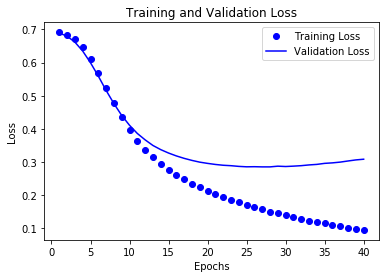

In [35]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# bo is for blue dot
plt.plot(epochs, loss, 'bo', label='Training Loss')

# b is for solid blue line
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

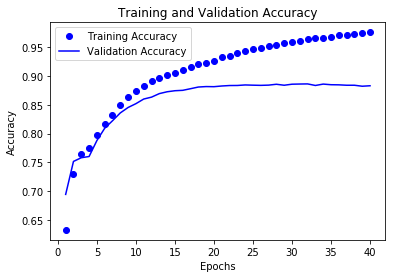

In [36]:
plt.figure()
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()